In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import math as mt
import scipy.special
import seaborn as sns
plt.style.use('fivethirtyeight')
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd

# <font face="gotham" color="orange"> Metropolis-Hastings Algorithm </font>

We have seen the _Metropolis algorithm_ in previous example, now we address the **Metropolis-Hastings Algorithm** which is a more general form of the former one.

The different between a Metropolis and a Metropolis-Hastings (MH) algorithm resides on acceptance rule, MH has a **correction factor**
$$
P_{\text {accept }}=\min \left(\frac{P\left(\lambda_{p} \mid y\right)g(\lambda_{c}|\lambda_{p})}{P\left(\lambda_{c} \mid y\right)g(\lambda_{p}|\lambda_{c})}, 1\right)
$$

where subscripts are simplified as $c$ and $p$ which represent _current_ and _proposed_ accordingly. The correction factor is 
$$
\frac{g(\lambda_{c}|\lambda_{p})}{g(\lambda_{p}|\lambda_{c})}
$$

The Metropolis–Hastings correction factor is the probability density of drawing the current value ($\lambda_c$) from a distribution that is centered on the proposed value ($\lambda_p$) divided by the probability density of drawing the proposed value ($\lambda_p$) from a distribution centered on the current value ($\lambda_c$). 

The intention of correction factor, as its name indicates, is to correct the asymmetry of proposed distribution. We have only used normal distribution so far, which automatically has $\frac{g(\lambda_{c}|\lambda_{p})}{g(\lambda_{p}|\lambda_{c})}=1$.

In this section, we can demonstrate how an asymmetrical proposed distribution works and how we can correct the asymmetry.

## <font face="gotham" color="orange"> Revisit Beta-Binomial Conjugates </font>

We will turn to a Beta-Binomial conjugate example to demonstrate HM algorithm and especially the mechanism of correction factor. To reproduce the example here.

<div style="background-color:Bisque; color:DarkBlue; padding:30px;">
Suppose we would to like to how estimate a basketball player's <i>free throw</i> probability. For the prior, since we don't know much about him, he can be either an excellent or an awful player, so we choose $\alpha_0=\beta_0=.5$, the subscript zero represent priors. The plot tells our subjective view toward the player, he either has very high or very low probability of scoring. 
</div> 

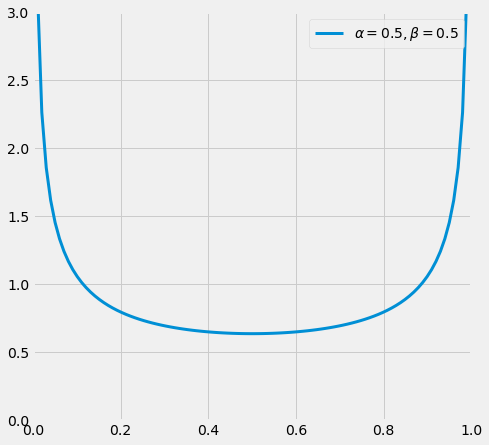

In [2]:
x = np.linspace(0, 1, 100)
params = [.5, .5]
beta_pdf = sp.stats.beta.pdf(x, params[0], params[1])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, beta_pdf, lw = 3, label = r'$\alpha = %.1f, \beta =  %.1f$' % (params[0], params[1]))
ax.legend()

ax.axis([0, 1, 0, 3])
plt.show()

The likelihood is binomial and posterior is again a beta distribution. However, in MH algorithm we need to specify one more distribution which is proposed distribution. 

Can we use a normal distribution as proposed distribution here? Well, technically you can, but it's not the ideal distribution. 

The problem is easy to see from the plot below. 

If the proposal distribution is centered close to $0$, the draw could easily return a negative number, as the light green shaded area on the left shows, which could be remedied by multiply $-1$. However if the proposal distribution is centered close to $1$ as shown in the darker green area on the right, the draw could be larger than $1$. It's attempted to correct these outliers by minus $1$, however there is no easy remedies for this issue, since the random draw can be $2$, $3$ or even larger numbers. 

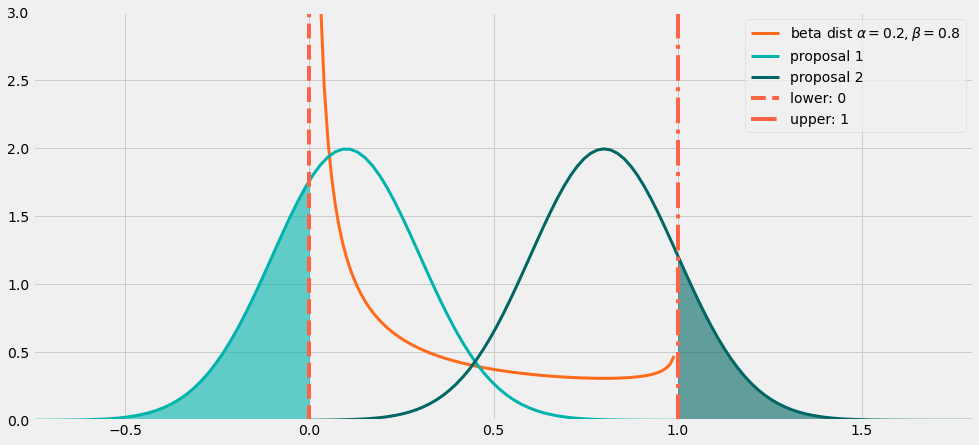

In [3]:
x_beta = np.linspace(0, 1, 100)
x_norm_1 = np.linspace(-1, 1, 100)
x_norm_2 = np.linspace(0, 1.8, 100)

params_beta = [.2, .8]
beta_pdf = sp.stats.beta.pdf(x_beta, params_beta[0], params_beta[1])

mu_1 = .1
sigma_1 = .2
norm_pdf_1 = sp.stats.norm.pdf(x_norm_1 ,loc=mu_1, scale=sigma_1)

mu_2 = .8
sigma_2 = .2
norm_pdf_2 = sp.stats.norm.pdf(x_norm_2 ,loc=mu_2, scale=sigma_2)

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(x_beta, beta_pdf, lw = 3, label = r'beta dist $\alpha = %.1f, \beta =  %.1f$' % (params_beta[0], params_beta[1]), 
        color='#FF6B1A')
ax.plot(x_norm_1, norm_pdf_1, lw = 3, label = r'proposal 1', color='#00B3AD')
ax.plot(x_norm_2, norm_pdf_2, lw = 3, label = r'proposal 2', color='#006663')

x_fill = np.linspace(-1, 0, 30)
y_fill = sp.stats.norm.pdf(x_fill, loc=mu_1, scale=sigma_1)
ax.fill_between(x_fill, y_fill, color ='#00B3AD', alpha=.6)

x_fill = np.linspace(1, 1.8, 30)
y_fill = sp.stats.norm.pdf(x_fill, loc=mu_2, scale=sigma_2)
ax.fill_between(x_fill, y_fill, color ='#006663', alpha=.6)

ax.axvline(0, color = 'tomato', ls='--', label='lower: {}'.format(0))
ax.axvline(1, color = 'tomato', ls='-.', label='upper: {}'.format(1))
ax.legend()
ax.axis([-.75, 1.8, 0, 3])
plt.show()

Therefore the best proposal distribution is bounded within $(0,\ 1)$, which is exactly a beta distribution does.

To summarize, our prior and posterior are beta distributions, so is proposal distribution of posterior!

Suppose the initial value $\lambda_{c} = .3$, the proposal distribution will be centered on $.3$, however beta distribution has two parameters $\alpha$ and $\beta$, in order to pin down a unique combination of parameters for proposal distribution, one parameter needs to be assumed fixed as a tuning parameter. 

Here we set $\beta=3$ as our tuning parameter. According to the formula of mean
$$
\mathrm{E}[X]=\frac{\alpha}{\alpha+\beta}=.3=\frac{\alpha}{\alpha+3}
$$
We pin down $\alpha=1.2857$.

In [4]:
lamda_c = .3
lamda_p = .4
beta = 3
alpha = .9/.7

Next we draw from this proposal distribution, say we got $\lambda_p = .4$.

With
$$
\lambda_{c} = .3\\
\lambda_{p} = .4
$$
Next we calculate the correction factor.

The denominator of correction factor $g(\lambda_{p} = .4|\ \lambda_{c} = .3)$ means the probability of $\lambda_{p} = .4$ from a beta distribution whose mean is $\lambda_{c} = .3$.

In [5]:
g_d = sp.stats.beta.pdf(x=lamda_p, a=alpha, b=beta)

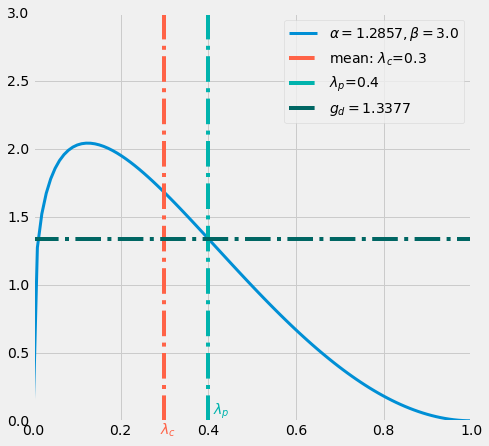

In [6]:
x = np.linspace(0, 1, 100)
beta_pdf = sp.stats.beta.pdf(x, alpha, beta)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, beta_pdf, lw = 3, label = r'$\alpha = %.4f, \beta =  %.1f$' % (alpha, beta))
ax.axvline(lamda_c, color = 'tomato', ls='-.', label='mean: $\lambda_c$={}'.format(lamda_c))
ax.text(.29, -.1, '$\lambda_c$', color='tomato')

ax.axvline(lamda_p, color = '#00B3AD', ls='-.', label='$\lambda_p$={}'.format(lamda_p))
ax.axhline(g_d, color = '#006663', ls='-.', 
           label=r'$g_d={:.4f}$'.format(g_d))
ax.text(.41, .05, '$\lambda_p$', color='#00B3AD')

ax.legend()

ax.axis([0, 1, 0, 3])
plt.show()

$$
\frac{g(\lambda_{c}|\lambda_{p})}{g(\lambda_{p}|\lambda_{c})}
$$

The numerator of correction factor $g(\lambda_{c} = .3|\ \lambda_{p} = .4)$ means the probability of $\lambda_{c} = .3$ from a beta distribution whose mean is $\lambda_{p} = .4$.

Again use the formula 
$$
\mathrm{E}[X]=\frac{\alpha}{\alpha+\beta}=.4=\frac{\alpha}{\alpha+3}
$$
We pin down $\alpha=2$.

In [7]:
beta = 3
alpha = 1.2/.6
g_n = sp.stats.beta.pdf(x=lamda_c, a=alpha, b=beta)

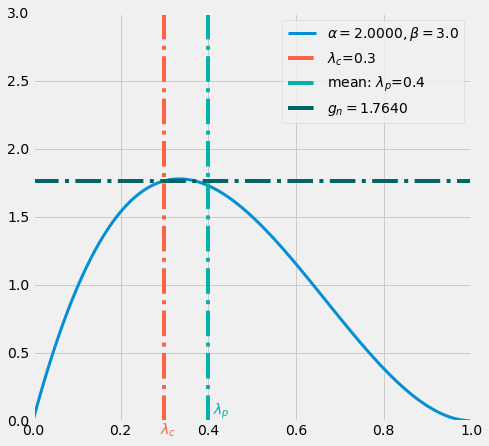

In [8]:
x = np.linspace(0, 1, 100)
beta_pdf = sp.stats.beta.pdf(x, alpha, beta)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(x, beta_pdf, lw = 3, label = r'$\alpha = %.4f, \beta =  %.1f$' % (alpha, beta))
ax.axvline(lamda_c, color = 'tomato', ls='-.', label='$\lambda_c$={}'.format(lamda_c))
ax.text(.29, -.1, '$\lambda_c$', color='tomato')

ax.axvline(lamda_p, color = '#00B3AD', ls='-.', label='mean: $\lambda_p$={}'.format(lamda_p))
ax.axhline(g_n, color = '#006663', ls='-.', 
           label='$g_n={:.4f}$'.format(g_n))
ax.text(.41, .05, '$\lambda_p$', color='#00B3AD')

ax.legend()


ax.legend()

ax.axis([0, 1, 0, 3])
plt.show()

Where 
$$
\frac{g_n}{g_d} = \frac{g(\lambda_{c}|\lambda_{p})}{g(\lambda_{p}|\lambda_{c})}
$$

The correction factor finally equals

In [9]:
cf = g_n/g_d; cf

1.3186423298548515

## <font face="gotham" color="orange"> MH Algorithm in Loop </font>

Building the likelihood function
$$
\mathcal{L}(k ; n, p)=\left(\begin{array}{l}
n \\
k
\end{array}\right) p^{k}(1-p)^{(n-k)}
$$

In [10]:
def binom_lh(n, k, lamda):
    lh = sp.special.binom(n, k)*lamda**k*(1-lamda)**(n-k)
    return lh

Building prior of beta distribution
$$
f(x ; \alpha, \beta)=\frac{1}{B(\alpha, \beta)} x^{\alpha-1}(1-x)^{\beta-1}
$$

In [11]:
def beta_prior(alpha, beta, lamda):
    prior = (1/sp.special.beta(alpha, beta))*lamda**(alpha-1)*(1-lamda)**(beta-1)
    return prior

Here's the full example Metropolis-Hastings algorithm.

In [12]:
def beta_binom_mh(lamda_init = .6, n= 10, k = 3, alpha_prparams = .5, beta_prparams= .5, tuning_beta = 3, chain_size = 10000): 
    np.random.seed(123)
    lamda_current = lamda_init

    lamda_mcmc = []
    pass_rate = []
    post_ratio_list = []

    for i in range(chain_size):
        # prior specification
        log_lh_current = np.log(binom_lh(n = n, k = k, lamda = lamda_current))
        log_prior_current = np.log(beta_prior(alpha=alpha_prparams, beta=beta_prparams, lamda=lamda_current))
        log_posterior_current = log_lh_current + log_prior_current
        
        # parameter specification for proposal distribution
        tuning_alpha = (lamda_current*tuning_beta)/(1-lamda_current)
        lamda_proposal = sp.stats.beta(a=tuning_alpha, b=tuning_beta).rvs()
        
        # proposal specification
        log_lh_proposal = np.log(binom_lh(n = n, k = k, lamda=lamda_proposal))
        log_prior_proposal = np.log(beta_prior(alpha=alpha, beta=beta, lamda=lamda_proposal))
        log_posterior_proposal = log_lh_proposal + log_prior_proposal
 
        # posterior ratio
        log_post_ratio = log_posterior_proposal - log_posterior_current
        post_ratio = np.exp(log_post_ratio)
        
        # Correction factor
        cf_denominator = sp.stats.beta.pdf(x=lamda_proposal, a=tuning_alpha, b=tuning_beta)
        
        cf_num_alpha = (lamda_proposal*tuning_beta)/(1-lamda_proposal)
        cf_numerator = sp.stats.beta.pdf(x=lamda_current, a=cf_num_alpha, b=tuning_beta)
        
        cf = cf_numerator/cf_denominator
        
        # acceptance rule
        prob_proposal = np.min([post_ratio*cf, 1])
        unif_draw = sp.stats.uniform.rvs()
        post_ratio_list.append(post_ratio)

        if unif_draw < prob_proposal:
            lamda_current = lamda_proposal
            lamda_mcmc.append(lamda_current)
            pass_rate.append('Y')
        else:
            lamda_mcmc.append(lamda_current)
            pass_rate.append('N')
    return lamda_mcmc, pass_rate

In [13]:
lamda_mcmc, pass_rate = beta_binom_mh(n= 10, k = 3, tuning_beta = 3, chain_size = 20000)

We will present the result as a histogram and a distribution plot. However this time the distribution plot will be obtained by **moment matching** rather than using analytical posterior form.

In [14]:
x = np.linspace(0, 1, 100)
alpha_pr, beta_pr = .5, .5
beta_pdf_prior = sp.stats.beta.pdf(x, a=alpha_pr, b=beta_pr)

In [15]:
from scipy.optimize import fsolve

def solve_equ(x, mu=np.mean(lamda_mcmc), sigma=np.std(lamda_mcmc)):
    a, b = x[0], x[1]
    F = np.empty(2)
    F[0] = a - mu*(a + b)
    F[1] = a*b - (a + b)**2 * (a + b + 1) * sigma**2
    return F
xGuess = np.array([6, 6])
z = fsolve(solve_equ, xGuess)

In [16]:
alpha_post, beta_post = z[0], z[1]
print('alpha_post: {}'.format(z[0]))
print('beta_post: {}'.format(z[1]))
beta_pdf_post = sp.stats.beta.pdf(x, a=alpha_post, b=beta_post)

alpha_post: 2.939505123132375
beta_post: 5.941038168915413


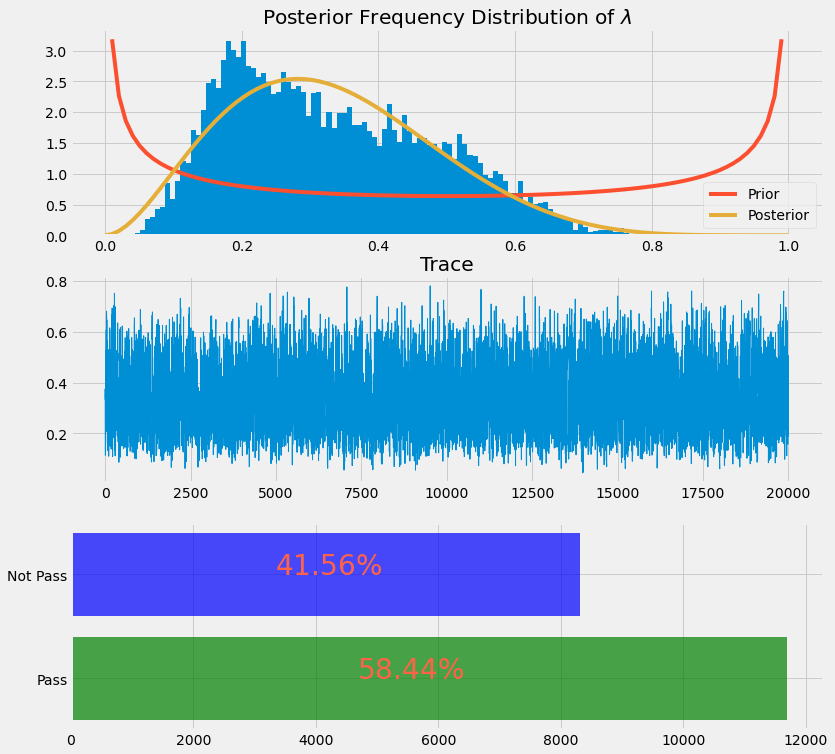

In [17]:
y_rate = pass_rate.count('Y')/len(pass_rate)
n_rate = pass_rate.count('N')/len(pass_rate)
yes = ['Pass','Not Pass']
counts = [pass_rate.count('Y'), pass_rate.count('N')]

fig, ax = plt.subplots(figsize = (12, 12), nrows = 3, ncols = 1)
ax[0].hist(lamda_mcmc, bins=100, density=True)
ax[0].set_title(r'Posterior Frequency Distribution of $\lambda$')
ax[0].plot(x, beta_pdf_prior, label='Prior')
ax[0].plot(x, beta_pdf_post, label='Posterior')
ax[0].legend()
ax[1].plot(np.arange(len(lamda_mcmc)), lamda_mcmc, lw=1)
ax[1].set_title('Trace')

ax[2].barh(yes, counts, color=['green', 'blue'], alpha=.7)
ax[2].text(counts[1]*.4, 'Not Pass', r'${}\%$'.format(np.round(n_rate*100,2)), color ='tomato', size = 28)
ax[2].text(counts[0]*.4, 'Pass', r'${}\%$'.format(np.round(y_rate*100,2)), color ='tomato', size = 28)
plt.show()

In [18]:
import numpy as np

def log_gaussian(x, mu, sigma):
    # The np.sum() is for compatibility with sample_MH
    return - 0.5 * np.sum((x - mu) ** 2) / sigma ** 2 \
           - np.log(np.sqrt(2 * np.pi * sigma ** 2))


class BivariateNormal(object):
    n_variates = 2

    def __init__(self, mu1, mu2, sigma1, sigma2):
        self.mu1, self.mu2 = mu1, mu2
        self.sigma1, self.sigma2 = sigma1, sigma2

    def log_p_x(self, x):
        return log_gaussian(x, self.mu1, self.sigma1)

    def log_p_y(self, x):
        return log_gaussian(x, self.mu2, self.sigma2)

    def log_prob(self, x):
        cov_matrix = np.array([[self.sigma1 ** 2, 0],
                               [0, self.sigma2 ** 2]])
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        kernel = -0.5 * (x - self.mu1) @ inv_cov_matrix @ (x - self.mu2).T
        normalization = np.log(np.sqrt((2 * np.pi) ** self.n_variates * np.linalg.det(cov_matrix)))

        return kernel - normalization


bivariate_normal = BivariateNormal(mu1=0.0, mu2=0.0, sigma1=1.0, sigma2=0.15)

In [19]:
bivariate_normal